# Gesture Recognition Using Conv3D Architecture

This notebook evaluates a Conv3D-based model designed for gesture recognition, which processes sequences of images to predict gesture classes.

## Model Architecture Summary
- **Input Shape**: `(sequence_length, height, width, 3)` (Sequence of RGB images).
- **Conv3D Layers**:
  - Three Conv3D layers with increasing filters (32, 64, 128).
  - Each Conv3D layer is followed by MaxPooling3D to reduce spatial-temporal dimensions.
- **Global Pooling**:
  - Global Average Pooling after the last Conv3D layer reduces feature dimensionality.
- **Fully Connected Layers**:
  - Dense layer with 128 units and ReLU activation.
  - Dropout with a rate of 50% to prevent overfitting.
- **Output Layer**:
  - Dense layer with `num_classes` units and softmax activation for multi-class classification.

In [15]:
train_data = './data/train'
train_labels = './data/train.csv'
val_data = './data/val'
val_labels = './data/val.csv'

In [16]:
from utilities import GestureDataGenerator, plot_training_history, set_seed, get_callbacks
set_seed(seed=42)

Random seed set to 42


In [17]:
load_fraction = 1.0             # Full data load
batch_size = 16                 # We are low on resources. We will go slow and steady.
image_size = (200, 200)

# Initialize the generator
train_generator = GestureDataGenerator(
    data_path=train_data,
    labels_csv=train_labels,
    batch_size=batch_size,
    image_size=image_size,
    # augmentations={
    #     'rotation': 5,       # Rotate up to ±5 degrees
    #     'brightness': True,  # Random brightness adjustment
    #     'contrast': True,    # Random contrast adjustment
    #     'scaling': True,     # Random scaling (zoom)
    #     'translation': True, # Random translation (shift)
    #     'blur': True         # Apply Gaussian blur
    # },    
    shuffle=True,
    load_fraction=load_fraction,
    debug=False,
    use_mediapipe=False,
)

val_generator = GestureDataGenerator(
    data_path=val_data,
    labels_csv=val_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=False,
    load_fraction=1.0,
    debug=False,
    use_mediapipe=False,
)

# Get the first batch
X, y = train_generator[0]

# Print outputs
print("Input batch shape (X):", X.shape)  # Expected shape: (batch_size, sequence_length, 224, 224, 3)
print("Labels batch shape (y):", y.shape)  # Expected shape: (batch_size, num_classes)
print("First label in batch (one-hot):", y[0])

42 batches created, each of size 16, with 663 sequences of 30 images each. Use MediaPipe: False
7 batches created, each of size 16, with 100 sequences of 30 images each. Use MediaPipe: False
Input batch shape (X): (16, 30, 200, 200, 3)
Labels batch shape (y): (16, 5)
First label in batch (one-hot): [0. 0. 0. 1. 0.]


In [18]:
# Define parameters
sequence_length = train_generator.sequence_length  # Frames per video (from generator)
image_size = train_generator.image_size            # Image size (height, width)
num_classes = train_generator.num_classes          # Number of gesture classes
input_shape = (sequence_length, image_size[0], image_size[1], 3)  # Conv3D input shape

In [19]:
from tensorflow.keras import layers, models

# Define the Conv3D model
model = models.Sequential([
    layers.Input(shape=(sequence_length, None, None, 3)),                        
    layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same'),
    layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same'),
    layers.Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.GlobalAveragePooling3D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Assuming 5 classes based on labels
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 200, 200, 32)  2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 15, 100, 100, 32)  0        
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 100, 100, 64)  55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 8, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 50, 50, 128)    221312    
                                                                 
 global_average_pooling3d_1   (None, 128)             

In [20]:
model_save_location = 'best-models/Conv3D-32-64-128'

In [21]:
checkpoint_callback, reduce_lr_callback, early_stopping_callback = get_callbacks(filepath = model_save_location)

Epoch 1/50
42/42 [==============================] - 30s 701ms/step - loss: 1.6139 - accuracy: 0.1931 - val_loss: 1.6037 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 29s 693ms/step - loss: 1.6088 - accuracy: 0.2172 - val_loss: 1.6036 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 29s 691ms/step - loss: 1.6113 - accuracy: 0.2247 - val_loss: 1.5791 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 29s 691ms/step - loss: 1.5780 - accuracy: 0.2594 - val_loss: 1.5871 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 29s 686ms/step - loss: 1.5354 - accuracy: 0.2775 - val_loss: 1.3963 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 29s 701ms/step - loss: 1.4127 - accuracy: 0.3695 - val_loss: 1.2265 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/50
42/42 [==============================] - 29s 695ms/st

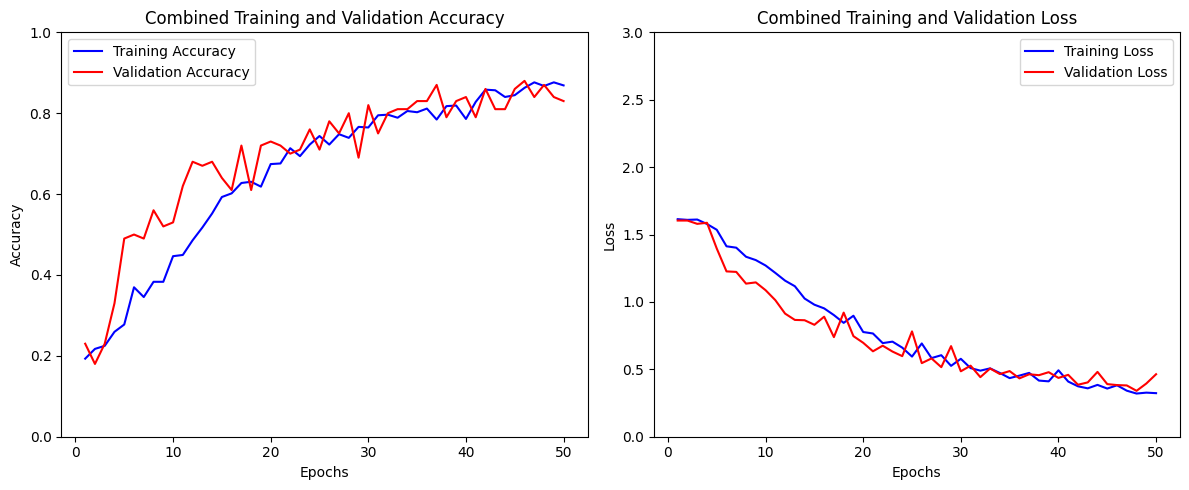

In [22]:
# Train the model
history_1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1])

Epoch 51/75
42/42 [==============================] - 30s 700ms/step - loss: 0.3326 - accuracy: 0.8703 - val_loss: 0.4511 - val_accuracy: 0.8400 - lr: 5.0000e-04
Epoch 52/75
42/42 [==============================] - 29s 697ms/step - loss: 0.3076 - accuracy: 0.8733 - val_loss: 0.3489 - val_accuracy: 0.8400 - lr: 5.0000e-04
Epoch 53/75
42/42 [==============================] - 29s 689ms/step - loss: 0.3264 - accuracy: 0.8688 - val_loss: 0.3597 - val_accuracy: 0.8600 - lr: 5.0000e-04
Epoch 54/75
42/42 [==============================] - 29s 702ms/step - loss: 0.3074 - accuracy: 0.8929 - val_loss: 0.4563 - val_accuracy: 0.8400 - lr: 5.0000e-04
Epoch 55/75
42/42 [==============================] - 29s 695ms/step - loss: 0.3410 - accuracy: 0.8673 - val_loss: 0.3731 - val_accuracy: 0.8600 - lr: 5.0000e-04
Epoch 56/75
42/42 [==============================] - 29s 702ms/step - loss: 0.3170 - accuracy: 0.8658 - val_loss: 0.3545 - val_accuracy: 0.8300 - lr: 5.0000e-04
Epoch 57/75
42/42 [===============

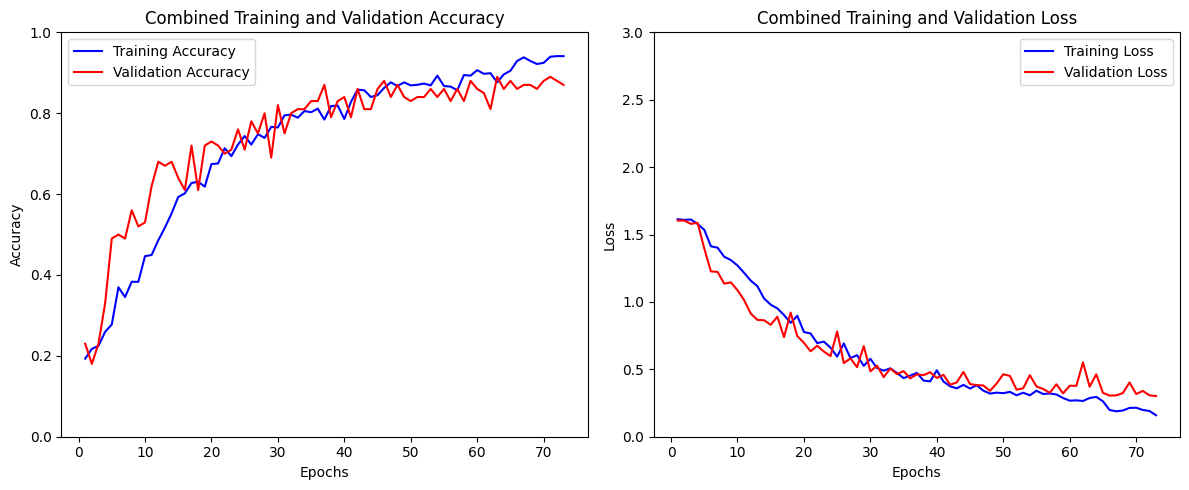

In [23]:
model.load_weights(model_save_location)

# Train the model for more epochs
history_2 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=75,                  # Train for more epochs
    initial_epoch=50,            # Start counting previous epochs
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1, history_2])

Epoch 76/100
42/42 [==============================] - 30s 704ms/step - loss: 0.2097 - accuracy: 0.9201 - val_loss: 0.3355 - val_accuracy: 0.8800 - lr: 1.2500e-04
Epoch 77/100
42/42 [==============================] - 29s 697ms/step - loss: 0.2098 - accuracy: 0.9246 - val_loss: 0.3094 - val_accuracy: 0.8900 - lr: 1.2500e-04
Epoch 78/100
42/42 [==============================] - 29s 700ms/step - loss: 0.2052 - accuracy: 0.9201 - val_loss: 0.3046 - val_accuracy: 0.8900 - lr: 1.2500e-04
Epoch 79/100
42/42 [==============================] - 29s 692ms/step - loss: 0.1914 - accuracy: 0.9216 - val_loss: 0.3257 - val_accuracy: 0.8700 - lr: 1.2500e-04
Epoch 80/100
42/42 [==============================] - 29s 696ms/step - loss: 0.2061 - accuracy: 0.9261 - val_loss: 0.2978 - val_accuracy: 0.8800 - lr: 1.2500e-04
Epoch 81/100
42/42 [==============================] - 29s 697ms/step - loss: 0.1867 - accuracy: 0.9306 - val_loss: 0.2800 - val_accuracy: 0.8900 - lr: 1.2500e-04
Epoch 82/100
42/42 [========

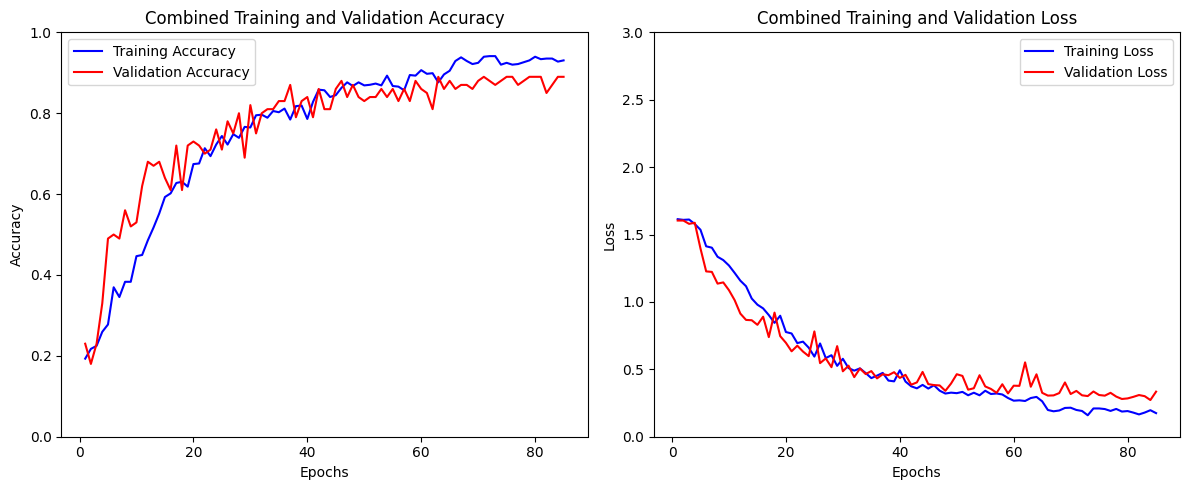

In [24]:
model.load_weights(model_save_location)

# Train the model for more epochs
history_3 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=100,                  # Train for more epochs
    initial_epoch=75,            # Start counting previous epochs
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1, history_2, history_3])

In [ ]:
model.load_weights(f'{model_save_location}.keras')

evaluation_results = model.evaluate(val_generator, verbose=1)
val_generator
for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

7/7 [==============================] - 4s 652ms/step - loss: 0.3709 - accuracy: 0.8900
loss: 0.3709
accuracy: 0.8900


In [ ]:
model.load_weights(f'{model_save_location}.keras')

evaluation_results = model.evaluate(train_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

42/42 [==============================] - 24s 578ms/step - loss: 0.1975 - accuracy: 0.9382
loss: 0.1975
accuracy: 0.9382


## Model Performance Summary

### Observations:
1. **Validation and Training Accuracy**:
   - Validation accuracy stabilizes at 89%, while training accuracy reaches 93.82%, suggesting minor overfitting but still generalizing well to unseen data.

2. **Loss Comparison**:
   - Training loss is low (0.1975), while validation loss (0.3709) is higher but stable, indicating effective learning with slight room for improvement.

3. **Learning Stability**:
   - Both accuracy and loss curves show consistent trends with minimal fluctuations, demonstrating stable convergence over 80+ epochs.

4. **Effectiveness of Conv3D**:
   - The Conv3D architecture successfully captures spatial-temporal features, critical for gesture recognition tasks involving sequences.

5. **Impact of Regularization**:
   - The dropout layer effectively reduces overfitting, as evidenced by the small accuracy gap between training and validation sets.

6. **Efficiency**:
   - The Adam optimizer and categorical crossentropy loss ensure efficient training, allowing the model to converge with strong performance metrics.

### Conclusions:
- The Conv3D model effectively learns spatial and temporal features for gesture recognition, achieving robust performance.
- Slight overfitting could be addressed with additional data augmentation or regularization techniques.
